In [58]:
# import numpy and pandas, and DataFrame / Series
import math
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import scipy.optimize as optimize

# Set some numpy options
np.set_printoptions(suppress=True)

# Set some pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# And some items for matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
#pd.options.display.mpl_style = 'default'

In [2]:
# Setup the parameters you will use for this part of the exercise
input_layer_size  = 400;  # 20x20 Input Images of Digits
num_labels = 10;          # 10 labels, from 1 to 10   
                          # (note that we have mapped "0" to label 10)

## =========== Part 1: Loading and Visualizing Data =============
###  We start the exercise by first loading and visualizing the dataset. 
###  You will be working with a dataset that contains handwritten digits.

In [49]:
X = np.loadtxt('mlclass-ex3/X.csv', delimiter=',')
y = np.loadtxt('mlclass-ex3/y.csv', delimiter=',')

m = len(y)
y=np.resize(y, (m,1))
y.shape

#% Randomly select 100 data points to display
rand_indices=np.random.permutation(m)

sel = X[rand_indices[1:100], :]


In [50]:
def displayData(X, example_width=None):
#DISPLAYDATA Display 2D data in a nice grid
#   [h, display_array] = DISPLAYDATA(X, example_width) displays 2D data
#   stored in X in a nice grid. It returns the figure handle h and the 
#   displayed array if requested.

    # Set example_width automatically if not passed in
    if example_width == None:
        example_width = round(math.sqrt(X.shape[1]));

    # Compute rows, cols
    m = X.shape[0]
    n = X.shape[1]
    example_height = round(n / example_width)
    
    # Compute number of items to display
    display_rows = math.floor(math.sqrt(m));
    display_cols = math.ceil(m / display_rows);

    # Between images padding
    pad = 1;
    
    # Setup blank display
    display_array = - np.ones((pad + (display_rows * (example_height + pad)), pad + (display_cols * (example_width + pad))))

    # Copy each example into a patch on the display array
    curr_ex = 0;
    for j in np.arange(display_rows):
        for i in np.arange(display_cols):
            if curr_ex > m : 
                break; 
            # Copy the patch

            # Get the max value of the patch
            max_val = np.amax(abs(X[curr_ex, :]));
            display_array_startx = j * (example_height + pad) #pad + (j * (example_height + pad)) - 1
            display_array_endx = ((j + 1) * (example_height + pad)) -1 # pad + (j * (example_height + pad))
            display_array_starty = i * (example_width + pad) # pad + (i * (example_width + pad))
            display_array_endy = ((i +1) * (example_width + pad)) - 1
                    
            de = (np.array(X[curr_ex, :]).reshape((example_height, example_width))) / max_val
            #print de.shape
            display_array[display_array_startx:display_array_endx, display_array_starty:display_array_endy] = (np.array(X[curr_ex, :]).reshape((example_height, example_width ))).T / max_val;
            curr_ex = curr_ex + 1;
        
        if curr_ex > m:
            break; 


    # Display Image
    plt.imshow(display_array, extent = [0,100,0,100], aspect='auto', cmap=plt.get_cmap('gray'))
    plt.show

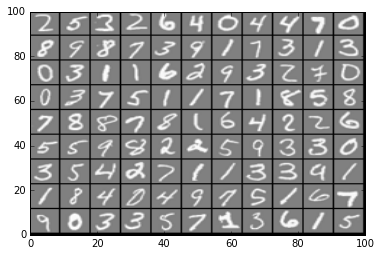

In [51]:
displayData(sel);

## ============ Part 2: Vectorize Logistic Regression ============
    In this part of the exercise, you will reuse your logistic regression
    code from the last exercise. You task here is to make sure that your
    regularized logistic regression implementation is vectorized. After
    that, you will implement one-vs-all classification for the handwritten
    digit dataset.


In [52]:
def sigmoid(z):
#SIGMOID Compute sigmoid functoon
#   J = SIGMOID(z) computes the sigmoid of z.

    g = 1.0 / (1.0 + math.exp(-z));
    return g

In [61]:
def lrCostFunction(theta_unraveled, X, y, lamda):
#LRCOSTFUNCTION Compute cost for logistic regression with 
#regularization
#   J = LRCOSTFUNCTION(theta, X, y, lambda) computes the cost of using
#   theta as the parameter for regularized logistic regression and the
#   gradient of the cost w.r.t. to the parameters. 

# Initialize some useful values
    m = y.shape[0] # number of training examples

# You need to return the following variables correctly 
    J = 0

# ====================== YOUR CODE HERE ======================
# Instructions: Compute the cost of a particular choice of theta.
#               You should set J to the cost.
#               Compute the partial derivatives and set grad to the partial
#               derivatives of the cost w.r.t. each parameter in theta
#
# Hint: The computation of the cost function and gradients can be
#       efficiently vectorized. For example, consider the computation
#
#           sigmoid(X * theta)
#
#       Each row of the resulting matrix will contain the value of the
#       prediction for that example. You can make use of this to vectorize
#       the cost function and gradient computations. 
#
# Hint: When computing the gradient of the regularized cost function, 
#       there're many possible vectorized solutions, but one solution
#       looks like:
#           grad = (unregularized gradient for logistic regression)
#           temp = theta; 
#           temp(1) = 0;   % because we don't add anything for j = 0  
#           grad = grad + YOUR_CODE_HERE (using the temp variable)
#
    theta = np.reshape(theta_unraveled, (theta_unraveled.shape[0], 1))
    tmp = 1/m*(-(y.T*math.log(sigmoid(X.dot(theta))))-(1-y).T*math.log(1-sigmoid(X.dot(theta)))) 
    J = tmp + (lamda/(2*m))*(theta[1:].T.dot(theta[1:]) ) 
    return J

In [62]:
def lrCostGradFunction(theta_unraveled, X, y, lamda):
#LRCOSTFUNCTION Compute gradient for logistic regression with 
#regularization
# Initialize some useful values
    m = y.shape[0] # number of training examples
    
    grad = np.zeros(theta_unraveled.shape)
    
    theta = np.reshape(theta_unraveled, (theta_unraveled.shape[0], 1))
    gradient_a = 1/m*((sigmoid(X.dot(theta))-y).T.dot(X))
    gradient_b = (lamda/m).dot(theta)
    gradient_b[0]=0;
    grad = gradient_a + gradient_b.T;
# =============================================================
    grad = grad.flatten(1)

In [63]:
def oneVsAll(X, y, num_labels, lamda):
#ONEVSALL trains multiple logistic regression classifiers and returns all
#the classifiers in a matrix all_theta, where the i-th row of all_theta 
#corresponds to the classifier for label i
#   [all_theta] = ONEVSALL(X, y, num_labels, lambda) trains num_labels
#   logisitc regression classifiers and returns each of these classifiers
#   in a matrix all_theta, where the i-th row of all_theta corresponds 
#   to the classifier for label i

# Some useful variables
    m = X.shape[0]
    n = X.shape[1]

# You need to return the following variables correctly 
    all_theta = np.zeros((num_labels, n+1))

# Add ones to the X data matrix
    X = np.hstack((np.ones((m,1)), X))

# ====================== YOUR CODE HERE ======================
# Instructions: You should complete the following code to train num_labels
#               logistic regression classifiers with regularization
#               parameter lambda. 
#
# Hint: theta(:) will return a column vector.
#
# Hint: You can use y == c to obtain a vector of 1's and 0's that tell use 
#       whether the ground truth is true/false for this class.
#
# Note: For this assignment, we recommend using fmincg to optimize the cost
#       function. It is okay to use a for-loop (for c = 1:num_labels) to
#       loop over the different classes.
#
#       fmincg works similarly to fminunc, but is more efficient when we
#       are dealing with large number of parameters.
#
# Example Code for fmincg:
#
#     % Set Initial theta
#     initial_theta = zeros(n + 1, 1);
#     
#     % Set options for fminunc
#     options = optimset('GradObj', 'on', 'MaxIter', 50);
# 
#     % Run fmincg to obtain the optimal theta
#     % This function will return theta and the cost 
#     [theta] = ...
#         fmincg (@(t)(lrCostFunction(t, X, (y == c), lambda)), ...
#                 initial_theta, options);
#
    for i in np.arange(1,num_labels):
        initial_theta = np.zeros(X.shape[1])    
        Result = optimize.minimize(fun = lrCostFunction, x0 = initial_theta, args = (X, y==i, lamda), method = 'TNC',
                                 jac = lrCostGradFunction)
        optimal_theta = Result.x
        all_theta[i,:] = optimal_theta.flatten(1)
    
    return all_theta

In [64]:
print ('\nTraining One-vs-All Logistic Regression...\n')

lamda = 0.1;
all_theta = oneVsAll(X, y, num_labels, lamda);


Training One-vs-All Logistic Regression...



TypeError: only length-1 arrays can be converted to Python scalars

(5000, 1)